# Reliability plots


## Base

In [33]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load predictions and targets from pickle file
pickle_file = "/workspace/logs/train/runs/HSN/eat/2025-08-29_103056/predictions/masked_test_predictions_20250829_103241.pkl"

with open(pickle_file, "rb") as f:
    data = pickle.load(f)

predictions = data["predictions"]
targets = data["targets"]
metadata = data["metadata"]

print(f"Loaded data with {metadata['total_samples']} samples")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Model info: {metadata['model_info']}")
print(f"Save logits: {metadata['save_logits']}")

# Display some basic statistics
print(f"\nPrediction statistics:")
print(f"  Min: {predictions.min():.4f}")
print(f"  Max: {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")
print(f"  Std: {predictions.std():.4f}")

print(f"\nTarget statistics:")
print(f"  Min: {targets.min():.4f}")
print(f"  Max: {targets.max():.4f}")
print(f"  Mean: {targets.mean():.4f}")
print(f"  Sum: {targets.sum():.0f} (total positive labels)")

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MCDropoutModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0056
  Std: 0.0436

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6254 (total positive labels)


In [44]:
import torch
import numpy as np
import pandas as pd

# Eingaben
pred = predictions
targ = targets

# Tensors -> float32
if isinstance(pred, torch.Tensor):
    pred = pred.detach().float().cpu()
if isinstance(targ, torch.Tensor):
    targ = targ.detach().float().cpu()

# Heuristik: Sind es schon Wahrscheinlichkeiten?
# (alles in [0,1] und kein Wert <0 oder >1)
already_probs = (pred.min() >= 0.0) and (pred.max() <= 1.0)

if already_probs:
    probs = pred
else:
    probs = torch.sigmoid(pred)

# Quick-Diagnose
print("pred min/max/mean BEFORE conversion:", float(pred.min()), float(pred.max()), float(pred.mean()))
print("probs min/max/mean AFTER conversion:", float(probs.min()), float(probs.max()), float(probs.mean()))

# Falls die Logits wirklich rund um 0 liegen:
# -> das Modell ist sehr unsicher; Histogramm checken hilft
# z.B.:
# import matplotlib.pyplot as plt
# plt.hist(pred.numpy().ravel(), bins=100); plt.show()

# In DataFrame gießen (wie raw_out.csv)
probs_np = probs.numpy()
targ_np  = targ.numpy()

if probs_np.ndim == 1:  probs_np = probs_np[:, None]
if targ_np.ndim  == 1:  targ_np  = targ_np[:, None]

n_classes = probs_np.shape[1]
pred_cols   = [f"prob_class_{i}" for i in range(n_classes)]
target_cols = [f"target_class_{i}" for i in range(n_classes)]

df = pd.DataFrame(np.hstack([probs_np, targ_np]), columns=pred_cols + target_cols)
print(df.head())
print("targets shape:", targets.shape)
print("targets dtype:", targets.dtype)
print("sum over all targets:", float(targets.sum()))
print("per-class sums (first 20):",
      [int(targets[:, i].sum()) for i in range(min(targets.shape[1], 20))])
print("metadata keys:", list(metadata.keys()))

pred min/max/mean BEFORE conversion: 0.0 1.0 0.005651229992508888
probs min/max/mean AFTER conversion: 0.0 1.0 0.005651229992508888
   prob_class_0  prob_class_1  prob_class_2  prob_class_3  prob_class_4  \
0      0.001028      0.006565      0.002621      0.002878      0.005260   
1      0.000072      0.000018      0.000170      0.000049      0.000022   
2      0.000005      0.108765      0.000612      0.000036      0.000688   
3      0.001636      0.000021      0.000220      0.000039      0.000019   
4      0.000003      0.000600      0.000150      0.000234      0.000185   

   prob_class_5  prob_class_6  prob_class_7  prob_class_8  prob_class_9  ...  \
0      0.004555      0.006958      0.005913      0.002424      0.003635  ...   
1      0.000019      0.000255      0.000495      0.000077      0.000051  ...   
2      0.000426      0.006145      0.001611      0.006958      0.000041  ...   
3      0.000010      0.000090      0.000132      0.000029      0.000018  ...   
4      0.000057  

In [34]:
# Convert predictions to probabilities if they are logits
# if metadata['save_logits']:
#     print("Converting logits to probabilities using sigmoid...")
#     probabilities = torch.sigmoid(predictions)
# else:
#     print("Predictions are already probabilities")
#     probabilities = predictions
probabilities = predictions

# Convert to numpy for easier manipulation
probs_np = probabilities.numpy()
targets_np = targets.numpy()

print(f"Probability statistics after conversion:")
print(f"  Min: {probs_np.min():.4f}")
print(f"  Max: {probs_np.max():.4f}")
print(f"  Mean: {probs_np.mean():.4f}")

# Check the shapes
print(f"\nData shapes:")
print(f"  Probabilities: {probs_np.shape}")
print(f"  Targets: {targets_np.shape}")

# For multilabel classification, we'll work with each class separately
num_classes = probs_np.shape[1] if len(probs_np.shape) > 1 else 1
print(f"  Number of classes: {num_classes}")

# Display class-wise statistics
if num_classes > 1:
    print(f"\nClass-wise positive label counts:")
    for i in range(num_classes):  # Show first 10 classes
        pos_count = targets_np[:, i].sum()
        print(
            f"  Class {i}: {pos_count:.0f} positive labels ({pos_count/len(targets_np)*100:.1f}%)"
        )

Probability statistics after conversion:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0056

Data shapes:
  Probabilities: (12000, 21)
  Targets: (12000, 21)
  Number of classes: 21

Class-wise positive label counts:
  Class 0: 671 positive labels (5.6%)
  Class 1: 2676 positive labels (22.3%)
  Class 2: 1082 positive labels (9.0%)
  Class 3: 22 positive labels (0.2%)
  Class 4: 735 positive labels (6.1%)
  Class 5: 1 positive labels (0.0%)
  Class 6: 175 positive labels (1.5%)
  Class 7: 28 positive labels (0.2%)
  Class 8: 320 positive labels (2.7%)
  Class 9: 27 positive labels (0.2%)
  Class 10: 17 positive labels (0.1%)
  Class 11: 3 positive labels (0.0%)
  Class 12: 266 positive labels (2.2%)
  Class 13: 126 positive labels (1.1%)
  Class 14: 18 positive labels (0.1%)
  Class 15: 1 positive labels (0.0%)
  Class 16: 3 positive labels (0.0%)
  Class 17: 62 positive labels (0.5%)
  Class 18: 7 positive labels (0.1%)
  Class 19: 7 positive labels (0.1%)
  Class 20: 7 positive labels (0.1%)

In [35]:
def compute_reliability_data(y_true, y_prob, n_bins=20):
    """
    Compute reliability diagram data for calibration analysis.

    Args:
        y_true: True binary labels (0 or 1)
        y_prob: Predicted probabilities
        n_bins: Number of bins for reliability diagram

    Returns:
        bin_boundaries, bin_lowers, bin_uppers, bin_accuracies, bin_confidences, bin_counts
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Determine if sample is in bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            count_in_bin = in_bin.sum()
        else:
            accuracy_in_bin = 0
            avg_confidence_in_bin = 0
            count_in_bin = 0

        bin_accuracies.append(accuracy_in_bin)
        bin_confidences.append(avg_confidence_in_bin)
        bin_counts.append(count_in_bin)

    return (
        bin_boundaries,
        bin_lowers,
        bin_uppers,
        bin_accuracies,
        bin_confidences,
        bin_counts,
    )


def plot_reliability_diagram(y_true, y_prob, n_bins=10, class_name="", ax=None):
    """
    Plot reliability diagram for calibration analysis.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    (
        bin_boundaries,
        bin_lowers,
        bin_uppers,
        bin_accuracies,
        bin_confidences,
        bin_counts,
    ) = compute_reliability_data(y_true, y_prob, n_bins)

    # Plot reliability diagram
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect calibration")

    # Only plot bins with samples
    valid_bins = [i for i, count in enumerate(bin_counts) if count > 0]
    if valid_bins:
        valid_confidences = [bin_confidences[i] for i in valid_bins]
        valid_accuracies = [bin_accuracies[i] for i in valid_bins]
        valid_counts = [bin_counts[i] for i in valid_bins]

        ax.plot(
            valid_confidences,
            valid_accuracies,
            "o-",
            linewidth=2,
            markersize=8,
            label=f'Model{" (" + class_name + ")" if class_name else ""}',
        )

        # Add bin count annotations
        for conf, acc, count in zip(valid_confidences, valid_accuracies, valid_counts):
            ax.annotate(
                f"{count}",
                (conf, acc),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
            )

    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Fraction of Positives")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Reliability Diagram{" - " + class_name if class_name else ""}')

    return ax


print("Reliability plotting functions defined!")

Reliability plotting functions defined!


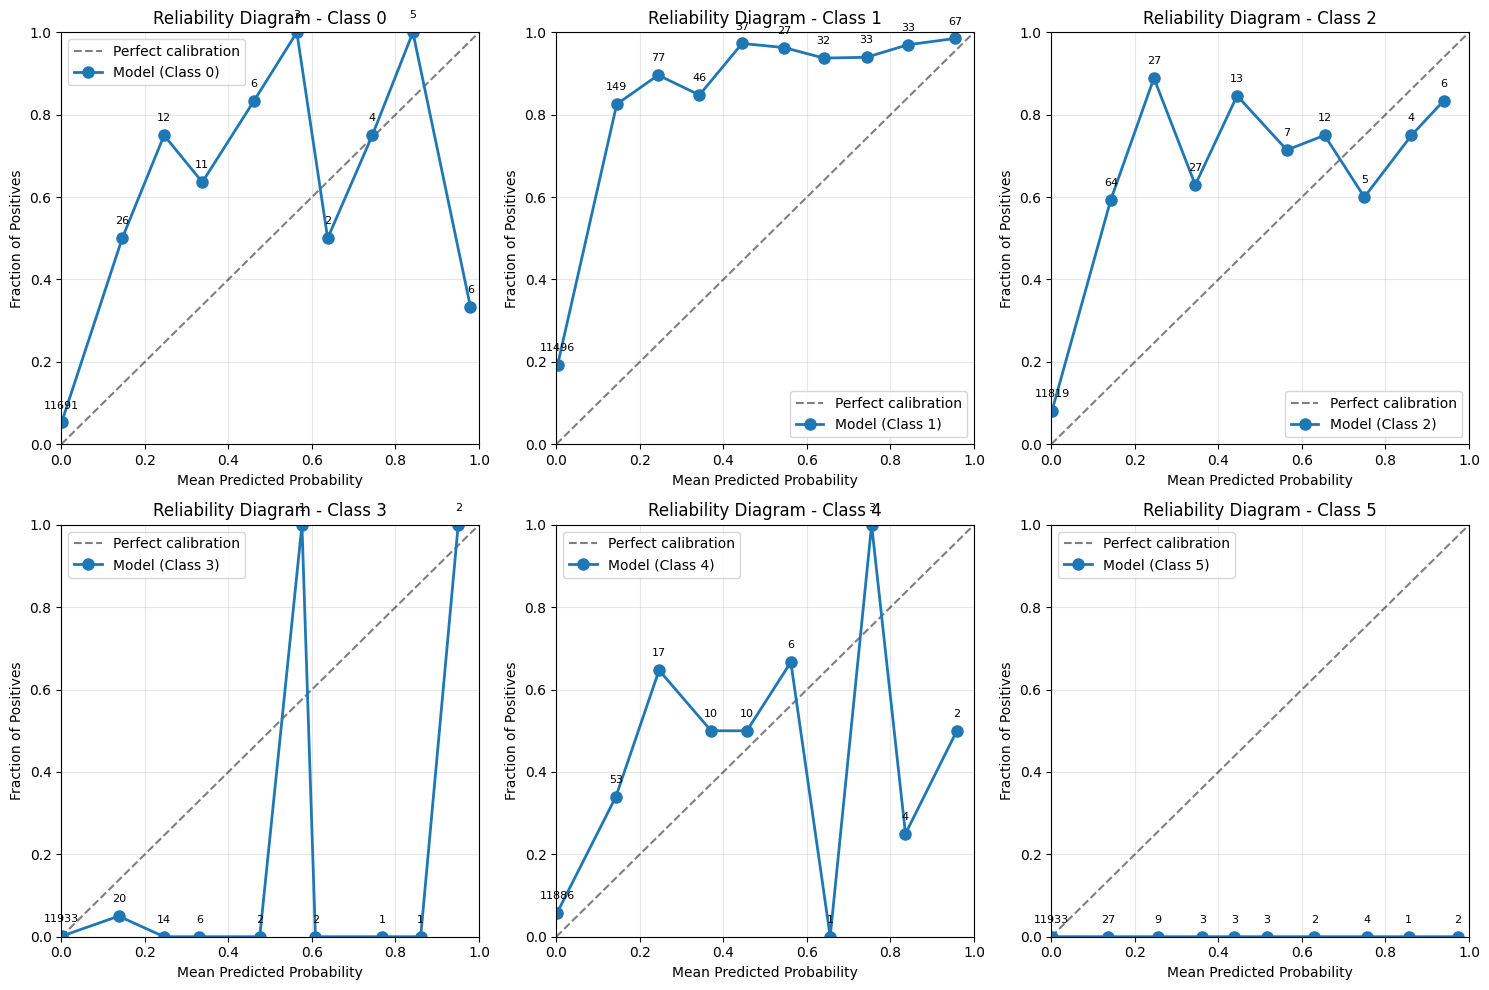

In [36]:
# Create reliability plots for the first few classes
n_classes_to_plot = min(6, num_classes)

if num_classes == 1:
    # Binary classification case
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plot_reliability_diagram(targets_np.flatten(), probs_np.flatten(), n_bins=20, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    # Multi-class case - plot first few classes
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(n_classes_to_plot):
        y_true_class = targets_np[:, i]
        y_prob_class = probs_np[:, i]

        # Only plot if there are positive samples for this class
        if y_true_class.sum() > 0:
            plot_reliability_diagram(
                y_true_class,
                y_prob_class,
                n_bins=10,
                class_name=f"Class {i}",
                ax=axes[i],
            )
        else:
            axes[i].text(
                0.5,
                0.5,
                f"Class {i}\n(No positive samples)",
                ha="center",
                va="center",
                transform=axes[i].transAxes,
            )
            axes[i].set_title(f"Class {i} - No positive samples")

    # Hide unused subplots
    for i in range(n_classes_to_plot, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

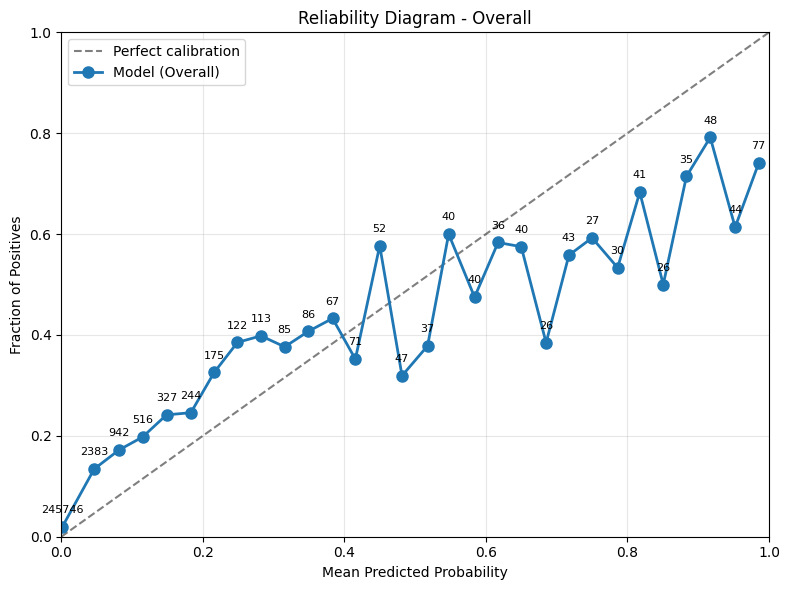

In [37]:
# plot a reliability diagram for each class combined, so we can see overall calibration
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
overall_y_true = targets_np.flatten() if num_classes == 1 else targets_np.ravel()
overall_y_prob = probs_np.flatten() if num_classes == 1 else probs_np.ravel()
plot_reliability_diagram(
    overall_y_true, overall_y_prob, n_bins=30, class_name="Overall", ax=ax
)
plt.tight_layout()
plt.show()

In [38]:
def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """
    Compute Expected Calibration Error (ECE) and Maximum Calibration Error (MCE).

    Args:
        y_true: True binary labels
        y_prob: Predicted probabilities
        n_bins: Number of bins

    Returns:
        ece, mce: Expected and Maximum Calibration Error
    """
    bin_boundaries, _, _, bin_accuracies, bin_confidences, bin_counts = (
        compute_reliability_data(y_true, y_prob, n_bins)
    )

    n_samples = len(y_true)
    ece = 0
    mce = 0

    for acc, conf, count in zip(bin_accuracies, bin_confidences, bin_counts):
        if count > 0:
            bin_weight = count / n_samples
            calibration_error = abs(acc - conf)
            ece += bin_weight * calibration_error
            mce = max(mce, calibration_error)

    return ece, mce


# Compute calibration metrics for each class
print("Calibration Metrics:")
print("=" * 50)

if num_classes == 1:
    ece, mce = compute_calibration_metrics(targets_np.flatten(), probs_np.flatten())
    print(f"ECE: {ece:.4f}")
    print(f"MCE: {mce:.4f}")
else:
    overall_eces = []
    overall_mces = []

    for i in range(num_classes):  # Show first 10 classes
        y_true_class = targets_np[:, i]
        y_prob_class = probs_np[:, i]

        if y_true_class.sum() > 0:  # Only compute for classes with positive samples
            ece, mce = compute_calibration_metrics(y_true_class, y_prob_class)
            overall_eces.append(ece)
            overall_mces.append(mce)
            print(
                f"Class {i:2d}: ECE={ece:.4f}, MCE={mce:.4f}, pos_samples={y_true_class.sum():.0f}"
            )
        else:
            print(f"Class {i:2d}: No positive samples")

    if overall_eces:
        print(f"\nOverall Statistics:")
        print(f"Mean ECE: {np.mean(overall_eces):.4f} ± {np.std(overall_eces):.4f}")
        print(f"Mean MCE: {np.mean(overall_mces):.4f} ± {np.std(overall_mces):.4f}")
        print(f"Median ECE: {np.median(overall_eces):.4f}")
        print(f"Median MCE: {np.median(overall_mces):.4f}")

print(f"\nDataset Summary:")
print(f"Total samples: {len(targets_np)}")
print(f"Total classes: {num_classes}")
if num_classes > 1:
    active_classes = np.sum(targets_np.sum(axis=0) > 0)
    print(f"Classes with positive samples: {active_classes}")
    avg_labels_per_sample = targets_np.sum() / len(targets_np)
    print(f"Average labels per sample: {avg_labels_per_sample:.2f}")

Calibration Metrics:
Class  0: ECE=0.0530, MCE=0.6462, pos_samples=671
Class  1: ECE=0.2011, MCE=0.6807, pos_samples=2676
Class  2: ECE=0.0839, MCE=0.6432, pos_samples=1082
Class  3: ECE=0.0010, MCE=0.8604, pos_samples=22
Class  4: ECE=0.0573, MCE=0.6558, pos_samples=735
Class  5: ECE=0.0028, MCE=0.9727, pos_samples=1
Class  6: ECE=0.0085, MCE=0.5202, pos_samples=175
Class  7: ECE=0.0030, MCE=0.9419, pos_samples=28
Class  8: ECE=0.0203, MCE=0.5160, pos_samples=320
Class  9: ECE=0.0012, MCE=0.9487, pos_samples=27
Class 10: ECE=0.0018, MCE=0.9707, pos_samples=17
Class 11: ECE=0.0105, MCE=0.9849, pos_samples=3
Class 12: ECE=0.0155, MCE=0.2041, pos_samples=266
Class 13: ECE=0.0086, MCE=0.7568, pos_samples=126
Class 14: ECE=0.0035, MCE=0.8232, pos_samples=18
Class 15: ECE=0.0038, MCE=0.9717, pos_samples=1
Class 16: ECE=0.0021, MCE=0.9492, pos_samples=3
Class 17: ECE=0.0063, MCE=0.9727, pos_samples=62
Class 18: ECE=0.0044, MCE=0.9561, pos_samples=7
Class 19: ECE=0.0025, MCE=0.9341, pos_sampl

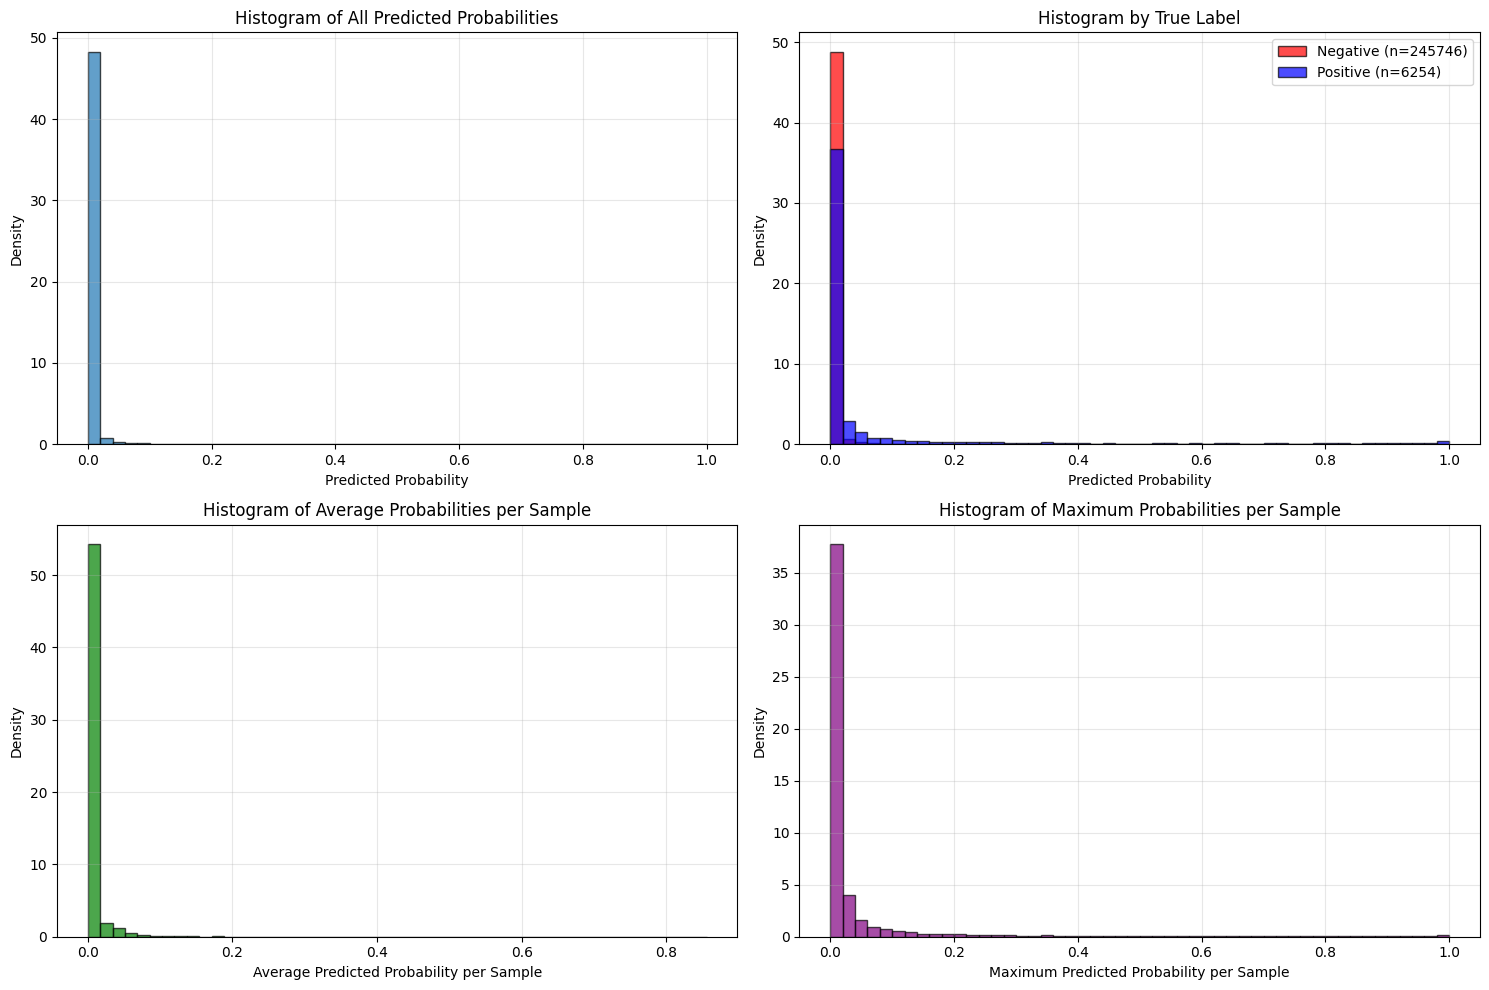

Probability Distribution Statistics:
Overall probabilities:
  Mean: 0.0056
  Median: 0.0003
  Std: 0.0436
  Min: 0.0000
  Max: 1.0000
  25th percentile: 0.0001
  75th percentile: 0.0012

Positive samples probabilities:
  Mean: 0.0744
  Median: 0.0021
  Std: 0.1953

Negative samples probabilities:
  Mean: 0.0039
  Median: 0.0003
  Std: 0.0293

Prediction confidence distribution:
  0.0-0.1: 249,500 predictions (99.0%)
  0.1-0.3: 1,502 predictions (0.6%)
  0.3-0.7: 625 predictions (0.2%)
  0.7-0.9: 203 predictions (0.1%)
  0.9-1.0: 168 predictions (0.1%)


In [39]:
# Plot histograms of prediction probabilities
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Overall histogram of all probabilities
ax = axes[0]
ax.hist(probs_np.flatten(), bins=50, alpha=0.7, edgecolor="black", density=True)
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Density")
ax.set_title("Histogram of All Predicted Probabilities")
ax.grid(True, alpha=0.3)

# Histogram separated by positive and negative samples
ax = axes[1]
# Flatten and create masks for positive and negative samples
all_probs = probs_np.flatten()
all_targets = targets_np.flatten()

positive_probs = all_probs[all_targets == 1]
negative_probs = all_probs[all_targets == 0]

ax.hist(
    negative_probs,
    bins=50,
    alpha=0.7,
    label=f"Negative (n={len(negative_probs)})",
    color="red",
    edgecolor="black",
    density=True,
)
ax.hist(
    positive_probs,
    bins=50,
    alpha=0.7,
    label=f"Positive (n={len(positive_probs)})",
    color="blue",
    edgecolor="black",
    density=True,
)
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Density")
ax.set_title("Histogram by True Label")
ax.legend()
ax.grid(True, alpha=0.3)

# Average probability per sample (for multilabel)
if num_classes > 1:
    ax = axes[2]
    sample_avg_probs = probs_np.mean(axis=1)
    ax.hist(
        sample_avg_probs,
        bins=50,
        alpha=0.7,
        edgecolor="black",
        density=True,
        color="green",
    )
    ax.set_xlabel("Average Predicted Probability per Sample")
    ax.set_ylabel("Density")
    ax.set_title("Histogram of Average Probabilities per Sample")
    ax.grid(True, alpha=0.3)

    # Max probability per sample
    ax = axes[3]
    sample_max_probs = probs_np.max(axis=1)
    ax.hist(
        sample_max_probs,
        bins=50,
        alpha=0.7,
        edgecolor="black",
        density=True,
        color="purple",
    )
    ax.set_xlabel("Maximum Predicted Probability per Sample")
    ax.set_ylabel("Density")
    ax.set_title("Histogram of Maximum Probabilities per Sample")
    ax.grid(True, alpha=0.3)
else:
    # For binary classification, hide unused subplots
    axes[2].set_visible(False)
    axes[3].set_visible(False)

plt.tight_layout()
plt.show()

# Print some statistics about the probability distributions
print("Probability Distribution Statistics:")
print("=" * 40)
print(f"Overall probabilities:")
print(f"  Mean: {probs_np.mean():.4f}")
print(f"  Median: {np.median(probs_np):.4f}")
print(f"  Std: {probs_np.std():.4f}")
print(f"  Min: {probs_np.min():.4f}")
print(f"  Max: {probs_np.max():.4f}")
print(f"  25th percentile: {np.percentile(probs_np, 25):.4f}")
print(f"  75th percentile: {np.percentile(probs_np, 75):.4f}")

print(f"\nPositive samples probabilities:")
print(f"  Mean: {positive_probs.mean():.4f}")
print(f"  Median: {np.median(positive_probs):.4f}")
print(f"  Std: {positive_probs.std():.4f}")

print(f"\nNegative samples probabilities:")
print(f"  Mean: {negative_probs.mean():.4f}")
print(f"  Median: {np.median(negative_probs):.4f}")
print(f"  Std: {negative_probs.std():.4f}")

# Show how many predictions are in different confidence ranges
confidence_ranges = [(0, 0.1), (0.1, 0.3), (0.3, 0.7), (0.7, 0.9), (0.9, 1.0)]
print(f"\nPrediction confidence distribution:")
for low, high in confidence_ranges:
    count = np.sum((probs_np >= low) & (probs_np < high))
    percentage = count / probs_np.size * 100
    print(f"  {low:.1f}-{high:.1f}: {count:,} predictions ({percentage:.1f}%)")